||Z - C||₂ = 3.41e+00, ||C1 - C2||₂ = 5.71e-01,  iteration = 0
||Z - C||₂ = 1.02e-03, ||C1 - C2||₂ = 4.22e-03,  iteration = 100
||Z - C||₂ = 2.29e-05, ||C1 - C2||₂ = 1.93e-02,  iteration = 200
||Z - C||₂ = 3.70e-07, ||C1 - C2||₂ = 1.95e-02,  iteration = 300
||Z - C||₂ = 5.38e-09, ||C1 - C2||₂ = 1.95e-02,  iteration = 400
ADMM Parallel computation time (Best Case):  0.027429391940434773


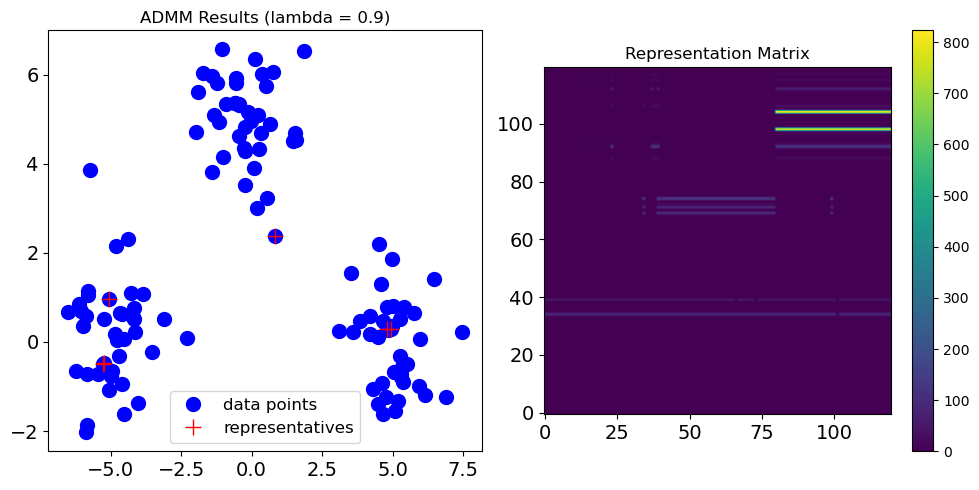

In [6]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time
# Computing similarities between source and target
def euclidean_distance(X, Y):
    return np.linalg.norm(X - Y)   

def computeDissimilarity(X, Y=None):
    if Y is None:
        Y = X

    M, N = X.shape[1], Y.shape[1]
    D = np.zeros((M, N))

    for i in range(M):
        for j in range(N):
            D[i, j] = euclidean_distance(X[:, i], Y[:, j])

    return D

def plot_results(Y, Z, sInd, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(Y[0, :], Y[1, :], 'o', linewidth=4, color='b', markersize=10, markerfacecolor='b')
    axs[0].plot(Y[0, sInd], Y[1, sInd], '+', linewidth=6, color='r', markersize=12)
    axs[0].legend(['data points', 'representatives'], fontsize=12)
    axs[0].set_title(title)
    axs[0].tick_params(labelsize=14)

    im = axs[1].imshow(Z)
    fig.colorbar(im, ax=axs[1])
    axs[1].set_title("Representation Matrix")
    axs[1].invert_yaxis()
    axs[1].tick_params(labelsize=14)

    plt.tight_layout()
    plt.show()
    
    
'''
Minimizing the Lagrangian function in (12) with respect to Z can be done in O(MN) computational time. 
We can obtain the solution in the case of p=2 via shrinkage and thresholding operation and 
in the case of p=∞ via projection onto the ℓ1 ball
'''
# z_solver(C1 - (lamda_var + D) / mu, lamda_reg / mu * dummy_D, p)
def z_solver(Z_old, lambda_val, p):
    Z_new = np.zeros_like(Z_old)
    if lambda_val.size > 0:
        D, N = Z_old.shape
        if p == 1:
            Z_new = np.maximum(np.abs(Z_old) - np.tile(lambda_val, (N, 1)).T, 0) * np.sign(Z_old)
        if p == 2:
            r = np.zeros(D)
            for j in range(D):
                r[j] = np.maximum(np.linalg.norm(Z_old[j, :], 2) - lambda_val[j], 0)
            Z_new = np.tile((r / (r + lambda_val)).reshape(-1, 1), (1, N)) * Z_old
        elif p == np.inf:
            Z_new = np.zeros((D, N))
            for j in range(D):
                y, t = Z_old[j, :],  lambda_val[j]
                x = y.copy()
                o = np.argsort(np.abs(y))[::-1]
                z = y[o]
                cs = np.cumsum(np.abs(z[:-1])) / np.arange(1, len(z))
                cs -= t / np.arange(1, len(z))
                d = cs > np.abs(z[1:])
                cut_index = len(y) if np.sum(d) == 0 else np.min(np.nonzero(d))
                zbar = np.mean(np.abs(z[:cut_index]))
                if cut_index < len(y):
                    x[o[:cut_index]] = np.sign(z[:cut_index]) * np.maximum(zbar - t / cut_index, np.abs(z[cut_index]))
                else:
                    x[o[:cut_index]] = np.sign(z[:cut_index]) * np.maximum(zbar - t / cut_index, 0)

                Z_new[j, :] = x
                
    return Z_new

'''
This part of the code is borrowed from the paper[4] section 3
'''

def solver_simplex(U):
    m, N = U.shape
    V = np.sort(U, axis=1)[:, ::-1] # Sorting the element of vector V
    activeElementSet = np.arange(N)
    theta = np.zeros(N)
    i = 0
    while activeElementSet.size > 0 and i < m:
        idx = (V[i, activeElementSet] - (np.sum(V[0:i+1, activeElementSet], axis=0) - 1) / (i + 1)) <= 0
        # print("idx: ", idx)
        theta[activeElementSet[idx]] = (np.sum(V[0:i, activeElementSet[idx]], axis=0) - 1) / i
        activeElementSet = activeElementSet[~idx]
        i += 1
    # print("theta: ", theta)
    if activeElementSet.size > 0:
        theta[activeElementSet] = (np.sum(V[0:m, activeElementSet], axis=0) - 1) / m
    C = np.maximum(U - np.tile(theta, (m, 1)), 0)
    return C

#Finding the effet of regularizer
def computeLamdaMax(D, q):
    M, N = D.shape
    idx = np.argmin(np.sum(D, axis=1))

    rho_max = -np.inf
    idxC = np.setdiff1d(np.arange(M), idx)
    
    if q == np.inf:
        for i in range(M - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = np.linalg.norm(v, 1) / 2
            if p > rho_max:
                lamda_max = p
    elif q == 2:
        for i in range(M - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = np.sqrt(M) * np.linalg.norm(v) ** 2 / (2 * np.sum(v))
            if p > rho_max:
                lamda_max = p

    return lamda_max

def solve_DS3_ADMM(D, p, lamda, maxIter):
    M, N = D.shape

    C1 = np.eye(M, N)
    lamda_var = np.zeros((M, N))
    mu = 1e-1
    epsilon = 1e-7

    error1 = 2 * epsilon
    error2 = 2 * epsilon
    dummy_D = np.ones(D.shape[0])
    lamda_reg = lamda * computeLamdaMax(D, p)
    
    k = 0
    while (error1 > epsilon or error2 > epsilon) and (k < maxIter):

        # Update Z
        # Z = np.linalg.solve((lamda / mu) * np.eye(M) + np.eye(M), (C1 - nu/ mu))
        Z = z_solver(C1 - (lamda_var + D)/ mu, lamda_reg / mu * dummy_D, p)
        # Update C
        # C2 = np.minimum(np.maximum(0, Z + (nu + D) / mu), 1)  # Use minimum operation 
        C2 = solver_simplex(Z + lamda_var / mu)
    
        # Update lamda_var
        lamda_var = lamda_var + mu * (Z - C2)

        # Update errors
        error1 = np.sum(np.abs(Z - C2)) / (Z.shape[0] * Z.shape[1])
        error2 = np.sum(np.abs(C1 - C2)) / (Z.shape[0] * Z.shape[1])
        
        if k % 100 == 0:
            print("||Z - C||₂ = {:.2e}, ||C1 - C2||₂ = {:.2e},  iteration = {}\n".format(error1, error2, k))

        # Update iteration counter
        k += 1
        
        C1 = C2

    return Z

def findRepresentatives(matrix, ratio=0.1):
    num_rows = matrix.shape[0]
    row_norms = np.zeros(num_rows)

    for i in range(num_rows):
        row_norms[i] = np.linalg.norm(matrix[i, :], np.inf)

    selected_indices = np.where(row_norms >= ratio * np.linalg.norm(row_norms, np.inf))[0]

    norms_selected = np.zeros(len(selected_indices))
    for i, ind in enumerate(selected_indices):
        norms_selected[i] = np.linalg.norm(matrix[ind, :], ord=2)

    sorted_indices = selected_indices[np.argsort(norms_selected)[::-1]]
    return sorted_indices

beta = 0.5  
tau = 1.0  
p = np.inf
# p = 2
maxIter_cvx = 3000
maxIter = 500
tolerance_factor_cvx = 0.0

# Generate source and target sets
np.random.seed(42)
# Parameters
num_groups = 3
points_per_group = 40
offsets = np.array([[0, 5], [5, 0], [-5, 0]])  

# Initialize an empty list to store groups of points
X_groups = []

# Generate each group of points with the corresponding offset
for offset in offsets[:num_groups]:
    X_group = np.random.randn(2, points_per_group) + np.expand_dims(offset, axis=1)
    X_groups.append(X_group)

# Concatenate all groups of points along the second axis
X = np.hstack(X_groups)

# Set Y equal to X
Y = X

# Compute dissimilarity matrix
D = computeDissimilarity(X, Y)
D /= np.max(D)

lamda = 0.9

start_time_ADMM = time.time()
Z_ADMM = solve_DS3_ADMM(D, p, lamda, maxIter)
end_time_ADMM = time.time()
ADMM_time = end_time_ADMM - start_time_ADMM
print("ADMM Parallel computation time (Best Case): ", ADMM_time / (num_groups * points_per_group)  )
sInd_numpy = findRepresentatives(Z_ADMM)
plot_results(Y, Z_ADMM, sInd_numpy, "ADMM Results (lambda = {})".format(lamda))